In [5]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import laplace_asymmetric
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [6]:
#import dataset
df_complete = pd.read_excel('EA_GDP.xlsx')
df_complete.head()


,TIME,RGDP,CISS,GDPlog,GDPgrowth(annualized),GDPgrowth/400
0,1991Q1,1.851747e+06,0.121591,14.431640,0.026317,0.000066
1,1991Q2,1.856938e+06,0.061375,14.434440,0.024727,0.000062
2,1991Q3,1.857512e+06,0.057187,14.434749,0.015219,0.000038
3,1991Q4,1.876601e+06,0.081339,14.444973,0.019042,0.000048
4,1992Q1,1.902687e+06,0.080447,14.458777,0.027137,0.000068


In [7]:
df = df_complete.drop('TIME', axis=1)
df.head()

,RGDP,CISS,GDPlog,GDPgrowth(annualized),GDPgrowth/400
0,1.851747e+06,0.121591,14.431640,0.026317,0.000066
1,1.856938e+06,0.061375,14.434440,0.024727,0.000062
2,1.857512e+06,0.057187,14.434749,0.015219,0.000038
3,1.876601e+06,0.081339,14.444973,0.019042,0.000048
4,1.902687e+06,0.080447,14.458777,0.027137,0.000068


In [8]:
rgdp = df['RGDP'].values.astype(float) 
ciss = df['CISS'].values.astype(float) 
rgdp_an = df['GDPgrowth(annualized)'].values.astype(float) 
rgdp_growth = df['GDPgrowth/400'].values.astype(float) 

rgdp_lag = np.roll(rgdp_an, 1)
rgdp_lag[0] = 0
rgdp_lag_growth = np.roll(rgdp_growth, 1)
rgdp_lag_growth[0] = 0

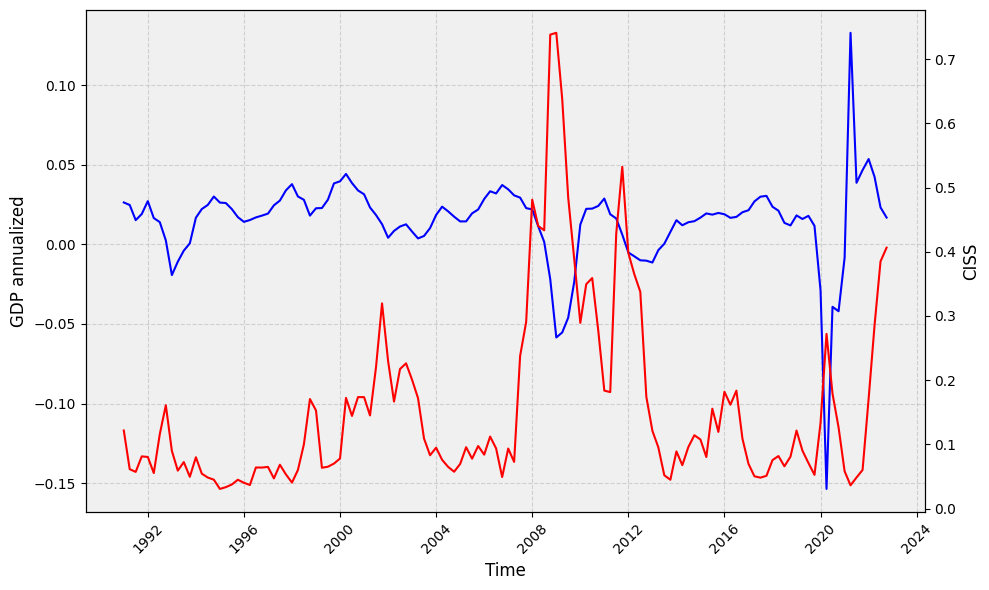

In [9]:
# Convert 'TIME' column to datetime
df_complete['TIME'] = pd.to_datetime(df_complete['TIME'])

# Create the fancy plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_complete['TIME'], df_complete['GDPgrowth(annualized)'], linestyle='-', color='b')

# Set plot title and labels
#ax.set_title('GDP Time Series and CISS', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('GDP annualized', fontsize=12)

# Customize the x-axis tick labels
ax.xaxis.set_tick_params(rotation=45, labelsize=10)
# Create a twin Axes for the secondary y-axis
ax2 = ax.twinx()
ax2.plot(df_complete['TIME'], df_complete['CISS'], linestyle='-', color='r')
ax2.set_ylabel('CISS', fontsize=12)
# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Add a background color to the plot
ax.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


In [10]:
''' QL regression with package'''
X = np.column_stack((np.ones_like(rgdp_an), rgdp_lag, ciss))

# Use the standardized variables in the regression analysis
quant_reg_1 = sm.QuantReg(rgdp_an, X).fit(q=0.1)
quant_reg_5 = sm.QuantReg(rgdp_an, X).fit(q=0.5)
quant_reg_9 = sm.QuantReg(rgdp_an, X).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary()) 



                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.4648
Model:                       QuantReg   Bandwidth:                    0.004994
Method:                 Least Squares   Sparsity:                      0.03425
Date:                Tue, 20 Jun 2023   No. Observations:                  128
Time:                        11:00:51   Df Residuals:                      125
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.472      0.638      -0.003       0.004
x1             0.8133      0.052     15.634      0.000       0.710       0.916
x2            -0.0325      0.008     -4.157      0.000      -0.048      -0.017
                         QuantReg Regression Results

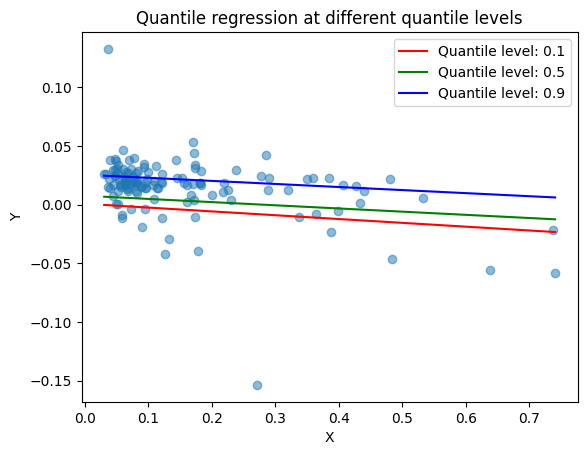

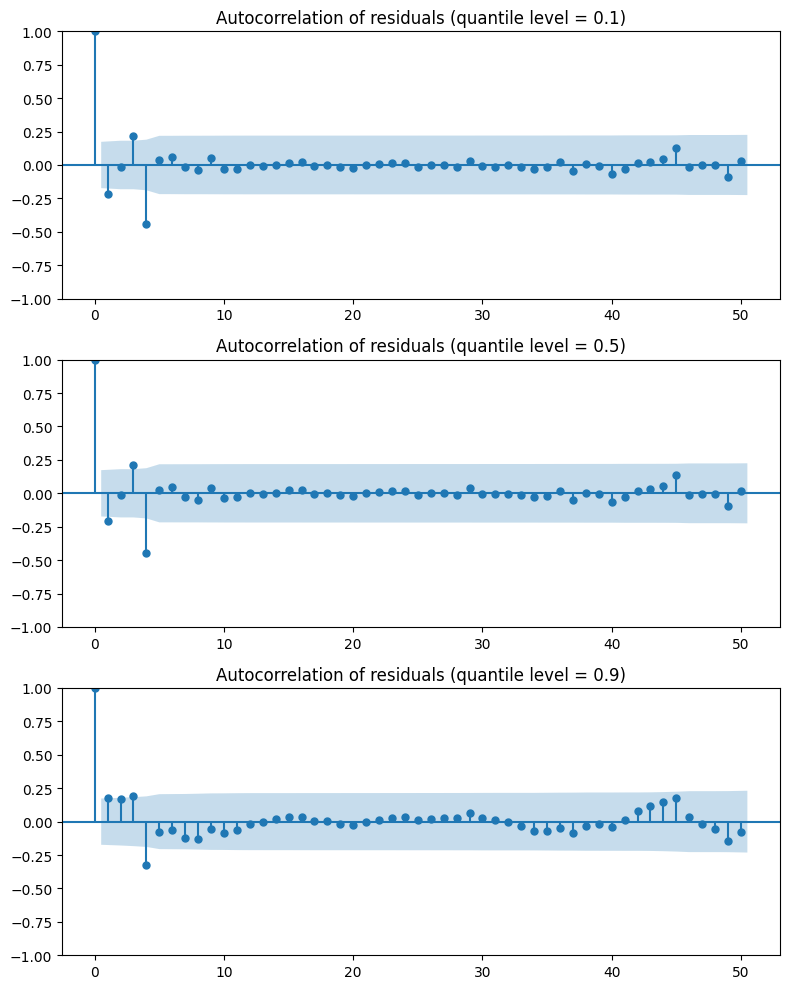

In [11]:
################################ Quantile regression plot ##############################
fig, ax = plt.subplots()
ax.scatter(ciss, rgdp_an, alpha=0.5)

    # Generate x values for the regression lines
x_vals = np.linspace(np.min(ciss), np.max(ciss), 100)
y_vals_lag = np.linspace(np.min(rgdp_lag), np.max(rgdp_lag), 100)
    # Plot the regression lines
ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Quantile regression at different quantile levels')
plt.show()

################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, lags=50, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, lags=50, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

In [12]:
# Perform Ljung-Box test with up to 10 lags
lbtest = acorr_ljungbox(residuals_1, lags=50)

# Print p-values for each lag
print(lbtest)

      lb_stat     lb_pvalue
1    6.367790  1.162103e-02
2    6.409466  4.056973e-02
3   12.858613  4.952557e-03
4   39.111716  6.605936e-08
5   39.275740  2.089869e-07
6   39.774218  5.044979e-07
7   39.795657  1.377365e-06
8   40.018515  3.178378e-06
9   40.357593  6.544687e-06
10  40.512653  1.376055e-05
11  40.640925  2.778095e-05
12  40.641736  5.623738e-05
13  40.646325  1.087236e-04
14  40.647177  2.020846e-04
15  40.696604  3.556747e-04
16  40.750632  6.043200e-04
17  40.765981  1.007977e-03
18  40.767175  1.639054e-03
19  40.803225  2.563315e-03
20  40.872907  3.867740e-03
21  40.874148  5.811481e-03
22  40.881481  8.512780e-03
23  40.924259  1.208065e-02
24  40.975046  1.676227e-02
25  41.016656  2.286491e-02
26  41.017959  3.090524e-02
27  41.019606  4.100752e-02
28  41.053128  5.310641e-02
29  41.236402  6.565983e-02
30  41.248352  8.286158e-02
31  41.277542  1.026794e-01
32  41.279938  1.260418e-01
33  41.321054  1.516123e-01
34  41.466028  1.772042e-01
35  41.515798  2.078

2.1810633213791935


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


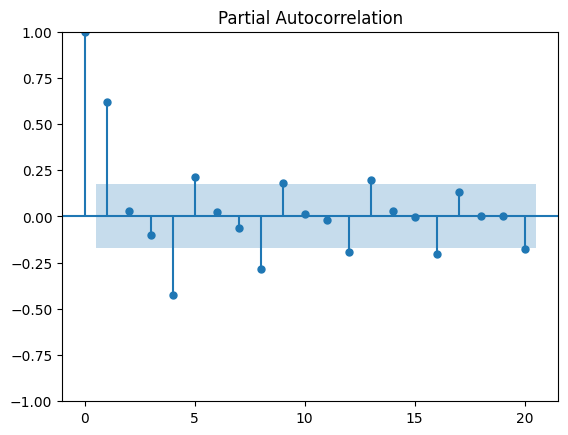

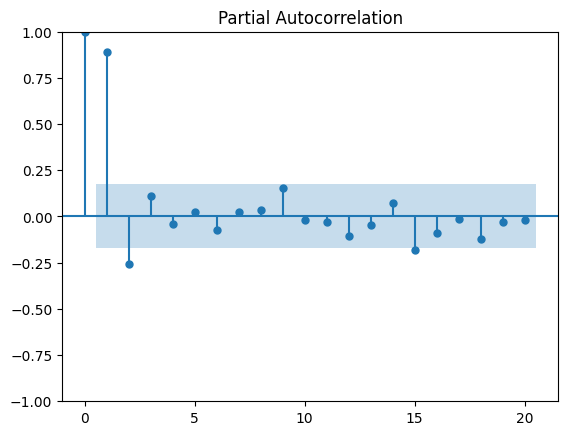

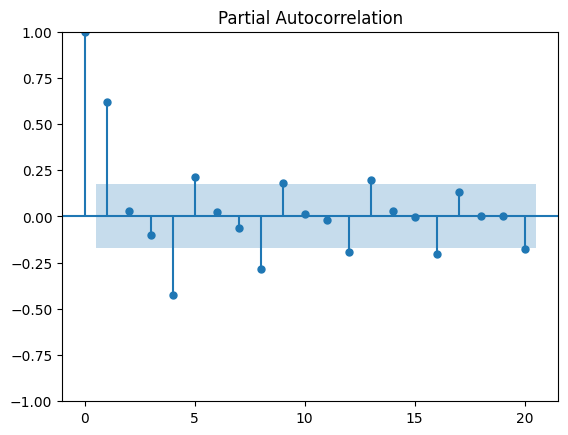

In [13]:
# Perform Durbin-Watson test
dwtest = durbin_watson(residuals_1)

# Print test statistic
print(dwtest)

# Plot PACF of the time series
plot_pacf(ciss, lags=20)
plot_pacf(rgdp_an, lags=20)

In [14]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['GDPgrowth(annualized)'].values
    T = min(M, len(y_dataset))
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        epsilon = np.random.randn(T) # Generate new errors for each iteration
        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.0077, 0.7821, -0.0271, 1])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")

In [15]:
M=1000
initial_params = 0.0077, 0.7821, -0.0271, 1, 0.0077, 0.7821, -0.0271, 1
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.14838298464622607]
OLS beta_hat:  [-0.03524024167890109]
OLS gamma_hat:  [-0.6125841528685614]
OLS theta_hat:  [0.9999999999999947]
GLS alpha_hat:  [0.14804702644683873]
GLS beta_hat:  [-0.030899676187180737]
GLS gamma_hat:  [-0.611625585723887]
GLS theta_hat:  [1.0000000000002274]
OLS_bias_param_0 = -0.1407
OLS_bias_param_1 = 0.8173
OLS_bias_param_2 = 0.5855
OLS_bias_param_3 = 0.0000
OLS_RMSE = 0.5076
GLS_bias_param_0 = -0.1403
GLS_bias_param_1 = 0.8130
GLS_bias_param_2 = 0.5845
GLS_bias_param_3 = -0.0000
GLS_RMSE = 0.5056


In [16]:
def Laplace_estimation(df, p, M, params0):

    def log_l_Asym_Lap(params, X, y):
        params = params
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))
        return -ll

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['GDPgrowth(annualized)'].values
    T = min(M, len(y_dataset))
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        #params0 = np.array([0.0077, 0.7821, -0.0271], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

        actuals = params0# True parameters alpha, beta, gamma
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix


In [17]:
params1 = np.array([0.0009, 0.8133, -0.0325], dtype=float)
result_matrix = Laplace_estimation(df, 0.1, 1000, params1)

Beta Matrix:
[[ 0.00090323  0.84671684 -0.03251128]
 [ 0.00091187  0.81499437 -0.03265799]
 [ 0.00093     0.84041    -0.03358333]
 ...
 [ 0.00093     0.84041    -0.030875  ]
 [ 0.00087587  0.82077826 -0.03265339]
 [ 0.00087854  0.84243163 -0.03380659]]

RMSE Matrix:
[[0.01929322 0.01929322 0.01929322]
 [0.00098252 0.00098252 0.00098252]
 [0.01566447 0.01566447 0.01566447]
 ...
 [0.01568007 0.01568007 0.01568007]
 [0.00431851 0.00431851 0.00431851]
 [0.01683607 0.01683607 0.01683607]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[ 0.00090731  0.8304308  -0.03278438]

Mean of RMSE:
0.012836716551085597


In [18]:
params5 = np.array([0.0009, 0.8133, -0.0325], dtype=float)#initial parametrs from OLS package p=0.5 
result_matrix = Laplace_estimation(df, 0.5, 1000, params5)

Beta Matrix:
[[ 0.0009    0.853965 -0.0325  ]
 [ 0.000945  0.8133   -0.0325  ]
 [ 0.0009    0.8133   -0.0325  ]
 ...
 [ 0.0009    0.8133   -0.0325  ]
 [ 0.000945  0.8133   -0.0325  ]
 [ 0.0009    0.8133   -0.0325  ]]

RMSE Matrix:
[[2.34779487e-02 2.34779487e-02 2.34779487e-02]
 [2.59807621e-05 2.59807621e-05 2.59807621e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.59807621e-05 2.59807621e-05 2.59807621e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[ 0.00091112  0.82108503 -0.03266234]

Mean of RMSE:
0.0052215950637781935


In [19]:
params9 = np.array([0.0256, 0.3915, -0.0261], dtype=float)#initial parametrs from OLS package p=0.9
result_matrix = Laplace_estimation(df, 0.5, 1000, params9)

Beta Matrix:
[[ 0.02570963  0.40405156 -0.02627219]
 [ 0.02654815  0.3712     -0.02706667]
 [ 0.02652741  0.3973     -0.02575563]
 ...
 [ 0.02581333  0.4056375  -0.0253025 ]
 [ 0.0256575   0.39330579 -0.0264531 ]
 [ 0.0256      0.39394688 -0.02724188]]

RMSE Matrix:
[[0.00724761 0.00724761 0.00724761]
 [0.01174625 0.01174625 0.01174625]
 [0.00339699 0.00339699 0.00339699]
 ...
 [0.00817619 0.00817619 0.00817619]
 [0.00106283 0.00106283 0.00106283]
 [0.00155896 0.00155896 0.00155896]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[ 0.02586565  0.39837923 -0.02638707]

Mean of RMSE:
0.0057638764353625275


In [20]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y_dataset = df['GDPgrowth(annualized)'].values
    #T = min(M, len(y_dataset))
    T = len(y_dataset)
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    y = np.array(y)
    x = np.array(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        #μ
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))
        #print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse
        #z[i+1] = mode_z_inverse
        #print('z[i+1]:', z[i+1])
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        actuals = β # True parameters alpha, beta, gamma
        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)

        print("\nMean of RMSE:")
        print(np.mean(rmse))

    return β_values

In [21]:
n = 1000
p = 0.1
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0009, 0.8133, -0.0325]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [-21342.46514745   -292.37313388  -3531.45224236]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 2: [-0.17687616 -0.00254723 -0.02771907]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 3: [-0.1671799   0.91924103 -0.08604668]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 4: [-0.16708609  0.91880438 -0.08660019]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 5: [-0.16730985  0.92197038 -0.08619491]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 6: [-0.16738673  0.92382047 -0.0860528 ]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 7: [-0.1678515   0.9224555  -0.08537423]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 8: [-0.16746533  0.92092865 -0.08593792]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 9: [-0.16841752  0.93562846 -0.08427197]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 10: [-0.16926625  0.95713325 -0.08253181]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 11: [-0.16743454  0.91018397 -0.08629614]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 12: [-0.16933115  0.95680989 -0.08244745]

RMSE:
0.0

Mean of RMSE:
0.0


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.13424651e+04, -2.92373134e+02, -3.53145224e+03],
       [-1.76876165e-01, -2.54722628e-03, -2.77190733e-02],
       [-1.67179898e-01,  9.19241026e-01, -8.60466753e-02],
       [-1.67086091e-01,  9.18804378e-01, -8.66001936e-02],
       [-1.67309853e-01,  9.21970384e-01, -8.61949073e-02],
       [-1.67386735e-01,  9.23820468e-01, -8.60528047e-02],
       [-1.67851499e-01,  9.22455497e-01, -8.53742349e-02],
       [-1.67465335e-01,  9.20928646e-01, -8.59379241e-02],
       [-1.68417518e-01,  9.35628457e-01, -8.42719656e-02],
       [-1.69266253e-01,  9.57133250e-01, -8.25318128e-02],
       [-1.67434544e-01,  9.10183968e-01, -8.62961408e-02],
       [-1.69331155e-01,  9.56809893e-01, -8.24474490e-02]])

In [22]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 50 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0077, 0.7821, -0.0271]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [-1138.23424434   303.35240679 -3933.23629873]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 2: [ 9.06741980e-06  1.01995461e-03 -6.44212227e-05]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 3: [  7.51609958 841.98767883 -53.21071667]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 4: [ 0.006794    0.77064238 -0.04854554]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 5: [ 0.00965724  1.11573323 -0.07000154]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 6: [ 0.00807173  0.92535474 -0.05827303]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 7: [ 0.00776793  0.93002122 -0.05780267]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 8: [ 0.00841838  0.92760863 -0.05877358]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 9: [ 0.00814034  0.93152443 -0.05829656]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 10: [ 0.00787913  0.93787179 -0.05776744]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 11: [ 0.00934006  0.9026863  -0.06071653]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 12: [ 0.00709553  0.95593089 -0.05620701]

RMSE:
0.0

Mean of RMSE:
0.0


Iteration 13: [ 0.00740433  0.94959228 -0.0568059 ]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 14: [ 0.00722131  0.95234486 -0.05646384]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 15: [ 0.0071439   0.95220812 -0.05633752]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 16: [ 0.00713972  0.95151223 -0.05634029]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 17: [ 0.00734838  0.95125288 -0.05669083]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 18: [ 0.00747448  0.95084223 -0.05690929]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 19: [ 0.00739058  0.95092826 -0.0567655 ]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 20: [ 0.00726722  0.95098967 -0.05655776]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 21: [ 0.00739342  0.9493369  -0.05679421]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 22: [ 0.00686576  0.95648339 -0.05580113]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 23: [ 0.00725744  0.95081878 -0.05654401]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 24: [ 0.00731684  0.9501709  -0.05665047]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 25: [ 

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.13823424e+03,  3.03352407e+02, -3.93323630e+03],
       [ 9.06741980e-06,  1.01995461e-03, -6.44212227e-05],
       [ 7.51609958e+00,  8.41987679e+02, -5.32107167e+01],
       [ 6.79399739e-03,  7.70642382e-01, -4.85455362e-02],
       [ 9.65724265e-03,  1.11573323e+00, -7.00015415e-02],
       [ 8.07172691e-03,  9.25354739e-01, -5.82730329e-02],
       [ 7.76793409e-03,  9.30021216e-01, -5.78026698e-02],
       [ 8.41838257e-03,  9.27608626e-01, -5.87735754e-02],
       [ 8.14034098e-03,  9.31524426e-01, -5.82965564e-02],
       [ 7.87913243e-03,  9.37871793e-01, -5.77674363e-02],
       [ 9.34005859e-03,  9.02686296e-01, -6.07165345e-02],
       [ 7.09552958e-03,  9.55930887e-01, -5.62070108e-02],
       [ 7.40432831e-03,  9.49592281e-01, -5.68059042e-02],
       [ 7.22131085e-03,  9.52344857e-01, -5.64638401e-02],
       [ 7.14389892e-03,  9.52208116e-01, -5.63375165e-02],
       [ 7.13972001e-03,  9.51512231e-01

In [23]:
n = 1000
p = 0.9
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0256, 0.3915, -0.0261]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [21230.9103587    322.58806307  3140.28153891]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 2: [0.17828668 0.00258306 0.02793912]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 3: [ 0.18557546  0.92489712 -0.03092696]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 4: [ 0.18550263  0.92331941 -0.03123148]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 5: [ 0.18528544  0.92651942 -0.03083596]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 6: [ 0.18520528  0.92849244 -0.03068744]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 7: [ 0.18473976  0.92695107 -0.03000873]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 8: [ 0.1851119   0.92544736 -0.03055546]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 9: [ 0.18413453  0.94060796 -0.02884644]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 10: [ 0.18325687  0.9629021  -0.02704847]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 11: [ 0.18511259  0.91514905 -0.03086591]

RMSE:
0.0

Mean of RMSE:
0.0
Iteration 12: [ 0.18322551  0.96155767 -0.02704455]

RMSE:
0.0

Mean of RMSE:
0.0


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.12309104e+04,  3.22588063e+02,  3.14028154e+03],
       [ 1.78286683e-01,  2.58305753e-03,  2.79391203e-02],
       [ 1.85575462e-01,  9.24897120e-01, -3.09269618e-02],
       [ 1.85502631e-01,  9.23319414e-01, -3.12314845e-02],
       [ 1.85285445e-01,  9.26519420e-01, -3.08359639e-02],
       [ 1.85205281e-01,  9.28492442e-01, -3.06874371e-02],
       [ 1.84739759e-01,  9.26951073e-01, -3.00087266e-02],
       [ 1.85111899e-01,  9.25447358e-01, -3.05554578e-02],
       [ 1.84134533e-01,  9.40607956e-01, -2.88464370e-02],
       [ 1.83256869e-01,  9.62902100e-01, -2.70484670e-02],
       [ 1.85112593e-01,  9.15149051e-01, -3.08659056e-02],
       [ 1.83225511e-01,  9.61557665e-01, -2.70445539e-02]])

Forecasting

In [28]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))
        

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)
        
    return mse_list


In [29]:
df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

#beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
beta_lap = np.array([0.0009, 0.8211, -0.0327]) 
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])
beta_pac = np.array([0.0077, 0.7821, -0.0271])  

betas = [beta_lap, beta_em, beta_ols, beta_gls, beta_pac]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls', 'beta_pac']

mse_values = []  # List to store the average MSE values for each horizon and beta combination

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list = recursive_poos(df_complete, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))

# Print the mse_values list
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MFSE for {beta_name}, horizon {horizon}: {avg_mse}")


Average MFSE for beta_lap, horizon 1: 0.0011991212971679648
Average MFSE for beta_lap, horizon 2: 0.001201865997974605
Average MFSE for beta_lap, horizon 3: 0.0012062057242947413
Average MFSE for beta_lap, horizon 4: 0.0012087111318029855
Average MFSE for beta_lap, horizon 5: 0.0012113287680518743
Average MFSE for beta_lap, horizon 6: 0.0012166251317881334
Average MFSE for beta_lap, horizon 7: 0.0012234386439438113
Average MFSE for beta_lap, horizon 8: 0.0012057717395190523
Average MFSE for beta_em, horizon 1: 0.0012810884368658253
Average MFSE for beta_em, horizon 2: 0.0012829152639213472
Average MFSE for beta_em, horizon 3: 0.0012870880316507777
Average MFSE for beta_em, horizon 4: 0.0012901569264238146
Average MFSE for beta_em, horizon 5: 0.0012941218382557438
Average MFSE for beta_em, horizon 6: 0.0013013782164665783
Average MFSE for beta_em, horizon 7: 0.0013101718067763464
Average MFSE for beta_em, horizon 8: 0.0012916399379065454
Average MFSE for beta_ols, horizon 1: 0.008083100

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df.index.unique()[:-horizon]
    mse_list = []
    y_lap_list = []
    y_em_list = []
    y_gls_list = []
    y_ols_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df.index <= vintage]
        df_test = df[df.index > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        # Append values for true y, y_lap, y_em, y_gls
        y_true_list.append(y_test)
        y_lap_list.append(X_test @ beta_lap)
        y_em_list.append(X_test @ beta_em)
        y_gls_list.append(X_test @ beta_gls)
        y_ols_list.append(X_test @ beta_ols)

    return mse_list, y_test, y_lap_list, y_em_list, y_gls_list, y_ols_list

# Read the DataFrame from Excel file
df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])

betas = [beta_lap, beta_em, beta_gls, beta_ols]
beta_names = ['beta_lap', 'beta_em', 'beta_gls', 'beta_ols']

mse_values = []  # List to store the average MSE values for each horizon and beta combination
y_lap_values = []  # List to store the values of y calculated with beta_lap
y_em_values = []  # List to store the values of y calculated with beta_em
y_gls_values = []  # List to store the values of y calculated with beta_gls
y_ols_values = []

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list, y_lap_list, y_em_list, y_gls_list, y_ols_list = recursive_poos(df, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))
        y_lap_values.append(y_lap_list)
        y_em_values.append(y_em_list)
        y_gls_values.append(y_gls_list)
        y_ols_values.append(y_ols_list)

# Print the MSE values
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MSE for {beta_name}, horizon {horizon}: {avg_mse}")

# Access the true values of y, y_lap, y_em, y_gls for a specific beta and horizon combination
# Example: accessing the true values of y for beta_lap and horizon 1
#beta_index = 0  # index of beta_lap in the betas list
#horizon_index = 0  # index of horizon 1 in the horizons list

#y_true = y_true_values[beta_index][horizon_index]
#y_lap = y_lap_values[beta_index][horizon_index]
#y_em = y_em_values[beta_index][horizon_index]
#y_gls = y_gls_values[beta_index][horizon_index]



NameError: name 'y_true_list' is not defined

In [ ]:
print(len(y_test))

NameError: name 'y_test' is not defined

In [ ]:
dm_test(y_true, y_ols_values, y_lap_values, one_sided=True)

InvalidParameterException: Actual timeseries and prediction series must have the same length.

In [ ]:
import numpy as np
from scipy.stats import norm

def diebold_mariano_test(errors1, errors2, h=1):
    n = len(errors1)
    d = np.abs(errors1) - np.abs(errors2)
    s = np.var(d)
    test_statistic = np.mean(d) / np.sqrt((1 / n) * s)
    p_value = 2 * (1 - norm.cdf(np.abs(test_statistic)))
    return test_statistic, p_value

# Define the forecast errors for each model
lap_errors = [0.0011139697285139102, 0.0011195670635388794, 0.0011258108459036725, 0.0011298776185967373,
              0.0011337497767893844, 0.0011399451012437012, 0.0011474594187636214, 0.0011313296533233624]

em_errors = [0.0012810884368658253, 0.0012829152639213472, 0.0012870880316507777, 0.0012901569264238146,
             0.0012941218382557438, 0.0013013782164665783, 0.0013101718067763464, 0.0012916399379065454]

gls_errors = [0.008053194712855028, 0.00800790897973031, 0.007967344620219363, 0.007947758770003113,
              0.007948306502827851, 0.007954888859141003, 0.00796287600625178, 0.007980016110644174]

ols_errors = [0.008083100651312309, 0.00803795071509084, 0.00799745002579299, 0.007977899923605206,
              0.00797847685691496, 0.007985066717916385, 0.007993068620486824, 0.0080103691390461]

# Perform Diebold-Mariano test for Lap model vs. OLS model
dm_lap_ols = diebold_mariano_test(lap_errors, ols_errors)
print("Diebold-Mariano test for Lap vs. OLS:")
print("Test Statistic:", dm_lap_ols[0])
print("p-value:", dm_lap_ols[1])
print()

# Perform Diebold-Mariano test for EM model vs. OLS model
dm_em_ols = diebold_mariano_test(em_errors, ols_errors)
print("Diebold-Mariano test for EM vs. OLS:")
print("Test Statistic:", dm_em_ols[0])
print("p-value:", dm_em_ols[1])
print()

# Perform Diebold-Mariano test for GLS model vs. OLS model
dm_gls_ols = diebold_mariano_test(gls_errors, ols_errors)
print("Diebold-Mariano test for GLS vs. OLS:")
print("Test Statistic:", dm_gls_ols[0])
print("p-value:", dm_gls_ols[1])


Diebold-Mariano test for Lap vs. OLS:
Test Statistic: -463.16164975051583
p-value: 0.0

Diebold-Mariano test for EM vs. OLS:
Test Statistic: -473.02879227473653
p-value: 0.0

Diebold-Mariano test for GLS vs. OLS:
Test Statistic: -707.8114925587232
p-value: 0.0


In [ ]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox

def diebold_mariano_test(errors1, errors2, h=1):
    # Calculate squared forecast errors
    squared_errors1 = np.array(errors1) ** 2
    squared_errors2 = np.array(errors2) ** 2

    # Calculate the differences of squared errors
    diff = squared_errors1 - squared_errors2

    # Check if there are sufficient data points for calculating auto-covariance
    if len(diff) <= h:
        print("Insufficient data points for calculating the auto-covariance.")
        return None

    # Calculate the auto-covariance of the differences
    _, Q, _, _ = acorr_ljungbox(diff, lags=[h], return_df=False)

    # Calculate the Diebold-Mariano test statistic
    dm_stat = np.mean(diff) / np.sqrt((h + 1) * np.mean(Q))

    return dm_stat

# Assuming you have already obtained the mse_by_horizon dictionary

# Perform Diebold-Mariano test for each horizon
for horizon, mse_list in mse_by_horizon.items():
    # Sort the MSE values based on the average MSE
    mse_list.sort(key=lambda x: x[1])

    # Get the best (lowest MSE) and the next best (second lowest MSE) methods
    best_beta, best_mse = mse_list[0]
    next_best_beta, next_best_mse = mse_list[1]

    # Extract the MSE values for the best and next best methods
    best_mse_values = [mse for beta, mse in mse_list if beta == best_beta]
    next_best_mse_values = [mse for beta, mse in mse_list if beta == next_best_beta]

    # Perform the Diebold-Mariano test if there are sufficient data points
    if len(best_mse_values) > horizon and len(next_best_mse_values) > horizon:
        dm_stat = diebold_mariano_test(best_mse_values, next_best_mse_values, horizon)

        # Print the results if the test is performed
        if dm_stat is not None:
            print(f"Diebold-Mariano test for horizon {horizon}:")
            print(f"Best method: {best_beta} (MSE: {best_mse})")
            print(f"Next best method: {next_best_beta} (MSE: {next_best_mse})")
            print(f"Diebold-Mariano test statistic: {dm_stat}\n")


In [30]:

def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        vintage_pd = pd.Timestamp(vintage)
        if horizon == 1 and vintage_pd.year in [2008, 2014] and vintage_pd.quarter == 4:
            print(f"Mean of y forecasted values for vintage {vintage}: {np.mean(y_forecast)}")

    return mse_list

df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])

betas = [beta_lap, beta_em, beta_ols, beta_gls]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls']

mse_values = []  # List to store the average MSE values for each horizon and beta combination

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list = recursive_poos(df_complete, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))

        if horizon == 1:
            print(f"Average MSE for {beta_name}, horizon {horizon}: {avg_mse}")

# Print the mse_values list
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MSE for {beta_name}, horizon {horizon}: {avg_mse}")


Mean of y forecasted values for vintage 2008-10-01T00:00:00.000000000: 0.00860914600860409
Mean of y forecasted values for vintage 2014-10-01T00:00:00.000000000: 0.015488387761969145
Average MSE for beta_lap, horizon 1: 0.0011139697285139102
Mean of y forecasted values for vintage 2008-10-01T00:00:00.000000000: 0.003961326420500044
Mean of y forecasted values for vintage 2014-10-01T00:00:00.000000000: 0.013786177874562329
Average MSE for beta_em, horizon 1: 0.0012810884368658253
Mean of y forecasted values for vintage 2008-10-01T00:00:00.000000000: 0.028581892212018584
Mean of y forecasted values for vintage 2014-10-01T00:00:00.000000000: 0.0690093319030545
Average MSE for beta_ols, horizon 1: 0.008083100651312309
Mean of y forecasted values for vintage 2008-10-01T00:00:00.000000000: 0.028467971837037802
Mean of y forecasted values for vintage 2014-10-01T00:00:00.000000000: 0.06885952195966259
Average MSE for beta_gls, horizon 1: 0.008053194712855028
Average MSE for beta_lap, horizon 1

In [ ]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    mean_values = []  # List to store the mean of y forecasted values

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        if horizon == 1 and (vintage == np.datetime64('2008-10-01') or vintage == np.datetime64('2014-10-01')):
            mean_values.append(np.mean(y_forecast))

    return mse_list, mean_values

df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])

betas = [beta_lap, beta_em, beta_ols, beta_gls]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls']

mse_values = []  # List to store the average MSE values for each horizon and beta combination
mean_values_all = []  # List to store the mean of y forecasted values for vintage 2008-10-01 and 2014-10-01

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list, mean_values = recursive_poos(df_complete, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))
        mean_values_all.extend(mean_values)

# Print the mse_values list
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MSE for {beta_name}, horizon {horizon}: {avg_mse}")

# Print the mean of y forecasted values for vintage 2008-10-01 and 2014-10-01 for each beta
vintage_2008_mean = mean_values_all[0::2]  # Extract mean values for vintage 2008-10-01
vintage_2014_mean = mean_values_all[1::2]  # Extract mean values for vintage 2014-10-01

for beta_name, mean_2008, mean_2014 in zip(beta_names, vintage_2008_mean, vintage_2014_mean):
    print(f"Mean of y forecasted values for vintage 2008-10-01 for {beta_name}: {mean_2008}")
    print(f"Mean of y forecasted values for vintage 2014-10-01 for {beta_name}: {mean_2014}")


Average MSE for beta_lap, horizon 1: 0.0011139697285139102
Average MSE for beta_lap, horizon 2: 0.0011195670635388794
Average MSE for beta_lap, horizon 3: 0.0011258108459036725
Average MSE for beta_lap, horizon 4: 0.0011298776185967373
Average MSE for beta_lap, horizon 5: 0.0011337497767893844
Average MSE for beta_lap, horizon 6: 0.0011399451012437012
Average MSE for beta_lap, horizon 7: 0.0011474594187636214
Average MSE for beta_lap, horizon 8: 0.0011313296533233624
Average MSE for beta_em, horizon 1: 0.0012810884368658253
Average MSE for beta_em, horizon 2: 0.0012829152639213472
Average MSE for beta_em, horizon 3: 0.0012870880316507777
Average MSE for beta_em, horizon 4: 0.0012901569264238146
Average MSE for beta_em, horizon 5: 0.0012941218382557438
Average MSE for beta_em, horizon 6: 0.0013013782164665783
Average MSE for beta_em, horizon 7: 0.0013101718067763464
Average MSE for beta_em, horizon 8: 0.0012916399379065454
Average MSE for beta_ols, horizon 1: 0.008083100651312309
Averag

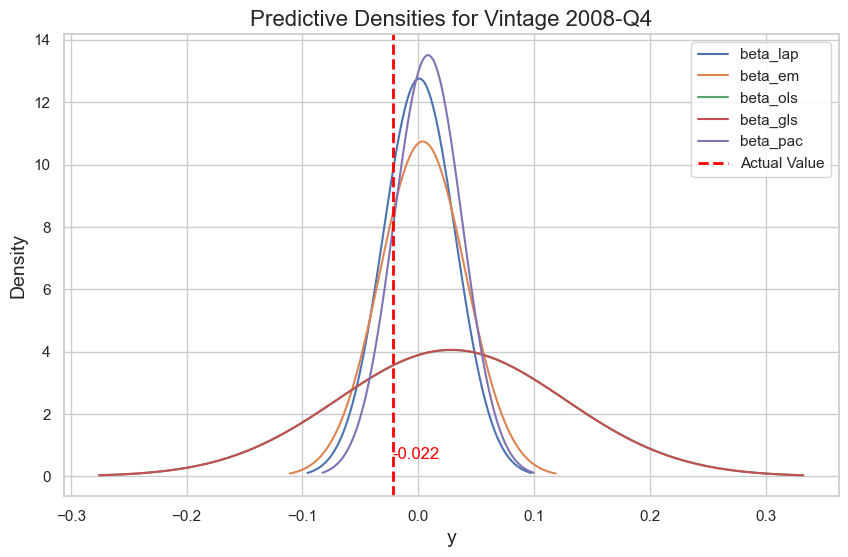

In [32]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []
    predictive_densities = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        if horizon == 1 and vintage == np.datetime64('2008-10-01'):
            predictive_density = norm(loc=np.mean(y_forecast), scale=np.std(y_forecast))
            predictive_densities.append(predictive_density)

    return mse_list, predictive_densities


df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizon = 1

beta_lap = np.array([0.0009, 0.8211, -0.0327]) 
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])
beta_pac = np.array([0.0077, 0.7821, -0.0271])  

betas = [beta_lap, beta_em, beta_ols, beta_gls, beta_pac]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls', 'beta_pac']

models = len(betas)

# Select the vintage for the plot
vintage = np.datetime64('2008-10-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'GDPgrowth(annualized)']
#ax.text(actual_value, 0.05, f'Actual Value: {actual_value:.3f}', color='red', fontsize=12, ha='center', va='center')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')


ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')

# Set the plot title and labels
ax.set_title(f'Predictive Densities for Vintage 2008-Q4', fontsize=16)
ax.set_xlabel('y', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()


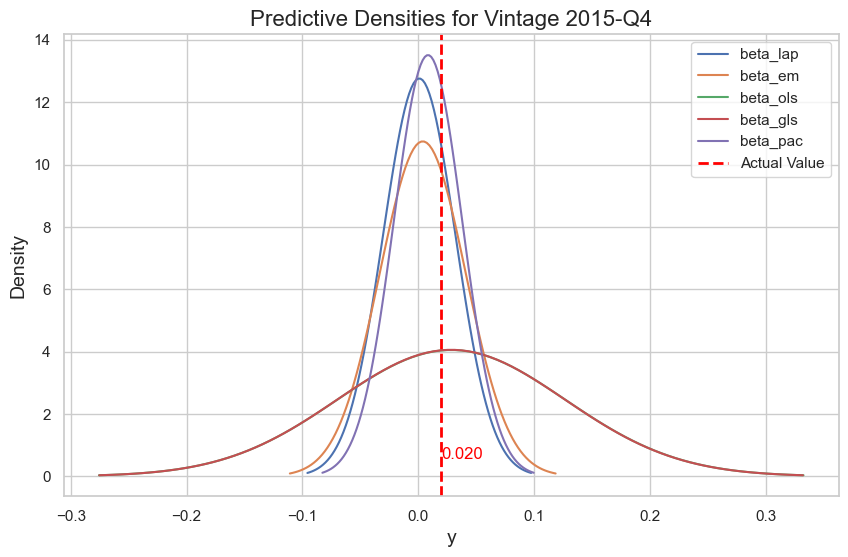

In [33]:
#Plot Vintage 2015-Q4
vintage = np.datetime64('2015-10-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'GDPgrowth(annualized)']
ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')

# Set the plot title and labels
ax.set_title(f'Predictive Densities for Vintage 2015-Q4', fontsize=16)
ax.set_xlabel('y', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()